# Example Notebook to demonstrate the usage of the SimplePybsmGenerator implementation

This example notebook demonstrates the use of the `SimplePysbmGenerator` class to generate Item-Response curves for a given input image, perturber and scorer metric.

## Table Of Contents
* [Environment Setup](#environment-setup)
* [Sample input image and detection](#sample-input-image-and-detection)
* [Initialize pipeline instances](#initialize-pipeline-instances)
* [Generate and Visualize Item-Response curves](#generate-and-visualize-item-response-curves)

## Environment Setup <a name="environment-setup"></a>

Note: We are suppressing warnings within this notebook to reduce visual clutter for demonstration purposes. If any issues arise while executing this notebook, we recommend that this cell is **not** executed so that any related warnings are shown. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys

!{sys.executable} -m pip install -qU pip
print("Installing torch and torchvision...")
!{sys.executable} -m pip install -q "torch!=2.0.1" torchvision
print("Installing headless OpenCV...")
!{sys.executable} -m pip uninstall -qy opencv-python opencv-python-headless  # make sure they're both gone.
!{sys.executable} -m pip install -q opencv-python-headless
print("Done!")

Installing torch and torchvision...
Installing headless OpenCV...
Done!


## Sample input image and detection <a name="sample-input-image-and-detection"></a>

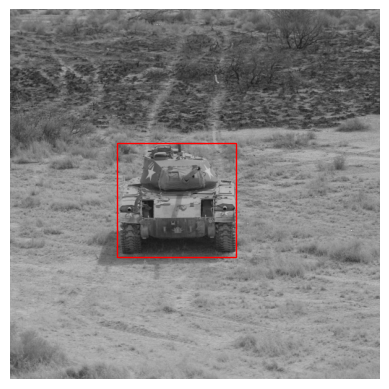

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import cv2
from smqtk_image_io.bbox import AxisAlignedBoundingBox

img_path = "./pybsm/data/M-41 Walker Bulldog (USA) width 319cm height 272cm.tiff"
img = cv2.imread(img_path)

gt = [(AxisAlignedBoundingBox([148, 185], [148+165, 185+158]), {"category": "tank"})]
imggsd = 3.19/165.0 #the width of the tank is 319 cm and it spans ~165 pixels in the image

bbox = gt[0][0]
width = bbox.max_vertex[0] - bbox.min_vertex[0]
height = bbox.max_vertex[1] - bbox.min_vertex[1]

fig, ax = plt.subplots()
ax.imshow(img)  # type: ignore
ax.set_axis_off()  # type: ignore
ax.add_patch(Rectangle(  # type: ignore
                (bbox.min_vertex[0], bbox.min_vertex[1]),
                width,
                height,
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            )) 
plt.show()

## Sample input sensor and scenario <a name="sample-sensor-and-scenario"></a>

In [4]:
import pybsm
from nrtk.impls.perturb_image.pybsm.scenario import PybsmScenario
from nrtk.impls.perturb_image.pybsm.sensor import PybsmSensor

#telescope focal length (m)
f=4
# Telescope diameter (m)
D=275e-3

#detector pitch (m)
p=.008e-3

#Optical system transmission, red  band first (m)
optTransWavelengths = np.array([0.85-.15,0.85+.15])*1.0e-6

L3 = PybsmSensor(
    # required
    name                = 'L32511x',
    D                   = D, # Telescope diameter (m)
    f                   = f, #telescope focal length (m)
    px                  = p, #detector pitch (m)
    optTransWavelengths = optTransWavelengths, #Optical system transmission, red  band first (m)

    # optional
    opticsTransmission  = 0.5*np.ones(optTransWavelengths.shape[0]), #guess at the full system optical transmission (excluding obscuration)
    eta                 = 0.4, #guess
    wx                  = p, #detector width is assumed to be equal to the pitch
    wy                  = p, #detector width is assumed to be equal to the pitch
    intTime             = 30.0e-3, #integration time (s) - this is a maximum, the actual integration time will be, determined by the well fill percentage
    darkCurrent         = pybsm.darkCurrentFromDensity(1e-5,p,p), #dark current density of 1 nA/cm2 guess, guess mid range for a silicon camera
    readNoise           = 25.0, #rms read noise (rms electrons)
    maxN                = 96000.0, #maximum ADC level (electrons)
    bitdepth            = 11.9, #bit depth
    maxWellFill         = .6, #maximum allowable well fill (see the paper for the logic behind this)
    sx                  = 0.25*p/f, #jitter (radians) - The Olson paper says that its "good" so we'll guess 1/4 ifov rms
    sy                  = 0.25*p/f, #jitter (radians) - The Olson paper says that its "good" so we'll guess 1/4 ifov rms
    dax                 = 100e-6, #drift (radians/s) - again, we'll guess that it's really good
    day                 = 100e-6, #drift (radians/s) - again, we'll guess that it's really good
    qewavelengths       = np.array([.3, .4, .5, .6, .7, .8, .9, 1.0, 1.1])*1.0e-6,
    qe                  = np.array([0.05, 0.6, 0.75, 0.85, .85, .75, .5, .2, 0])
)

S = PybsmScenario(
        name='niceday',
        ihaze=1, #weather model
        altitude=9000.0, #sensor altitude
        groundRange=0.0, #range to target

        aircraftSpeed=100.0
        )

## Initialize pipeline instances <a name="initialize-pipeline-instances"></a>

In the cell below, we initialize the model, perturber factory, generator and the scorer instances needed for our pipeline.

In [5]:
from smqtk_detection.impls.detect_image_objects.resnet_frcnn import ResNetFRCNN
from nrtk.impls.perturb_image_factory.generic.step import StepPerturbImageFactory
from nrtk.impls.perturb_image.generic.cv2.blur import GaussianBlurPerturber
from nrtk.impls.gen_object_detector_blackbox_response.simple_pybsm_generator import SimplePybsmGenerator
from nrtk.impls.score_detections.class_agnostic_pixelwise_iou_scorer import ClassAgnosticPixelwiseIoUScorer
from nrtk.impls.perturb_image_factory.pybsm import CustomPybsmPerturbImageFactory

perturber_factory = CustomPybsmPerturbImageFactory(L3, S,
                theta_keys=[    'altitude',
                                'groundRange'],
                thetas=[    
                            PybsmScenario.altitude_values[10:19:2],
                            PybsmScenario.groundRange_values[12:19]                                
                            ]
                )

detector = ResNetFRCNN(use_cuda=False, num_dets=1)
detector.get_model()

scorer = ClassAgnosticPixelwiseIoUScorer()

generator = SimplePybsmGenerator(images=[img], imggsds=[imggsd], groundtruth=[gt])  # type: ignore

## Generate Item-Response curves <a name="generate-and-visualize-item-response-curves"></a>

In [6]:
import torch  # type: ignore
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

curve, full = generator(
                blackbox_perturber_factories=[perturber_factory],
                blackbox_detector=detector,
                blackbox_scorer=scorer,
                img_batch_size=1,
                verbose=True
            )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:55<00:00,  1.59s/it]


## Show Item-Response curve parameter-values

In [7]:
for itm in curve:
    print(itm[0], itm[1])

{'altitude': 5000, 'groundRange': 10000} 0.48669010547463587
{'altitude': 5000, 'groundRange': 11000} 0.30619511037265607
{'altitude': 5000, 'groundRange': 12000} 0.19135535041823573
{'altitude': 5000, 'groundRange': 13000} 0.11840157868771584
{'altitude': 5000, 'groundRange': 14000} 0.06365159128978225
{'altitude': 5000, 'groundRange': 15000} 0.03345675747156837
{'altitude': 5000, 'groundRange': 16000} 0.00916030534351145
{'altitude': 7000, 'groundRange': 10000} 0.28423681711049353
{'altitude': 7000, 'groundRange': 11000} 0.18430379746835443
{'altitude': 7000, 'groundRange': 12000} 0.1188707280832095
{'altitude': 7000, 'groundRange': 13000} 0.06998813760379596
{'altitude': 7000, 'groundRange': 14000} 0.02656779942807741
{'altitude': 7000, 'groundRange': 15000} 0.013667808449190678
{'altitude': 7000, 'groundRange': 16000} 0.0009518305741577999
{'altitude': 9000, 'groundRange': 10000} 0.15339654059197336
{'altitude': 9000, 'groundRange': 11000} 0.0990990990990991
{'altitude': 9000, 'gro

## Show Item-Response curve plots

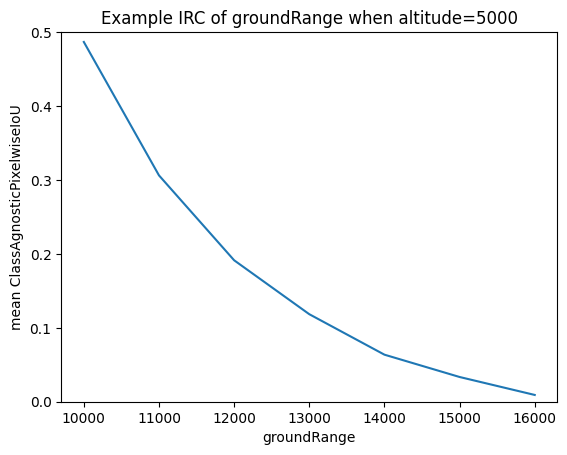

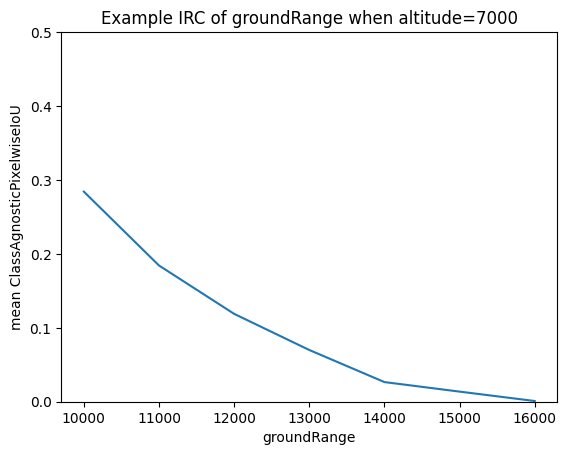

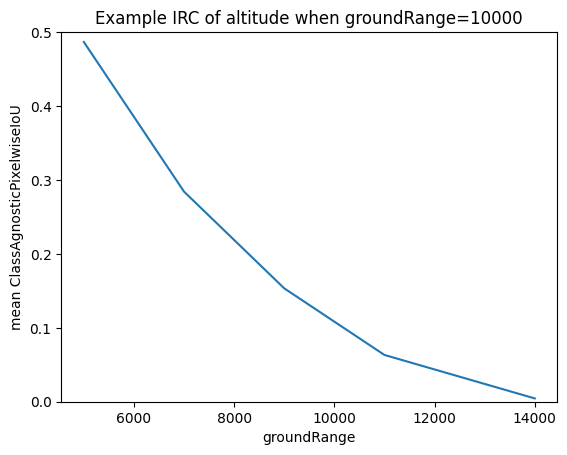

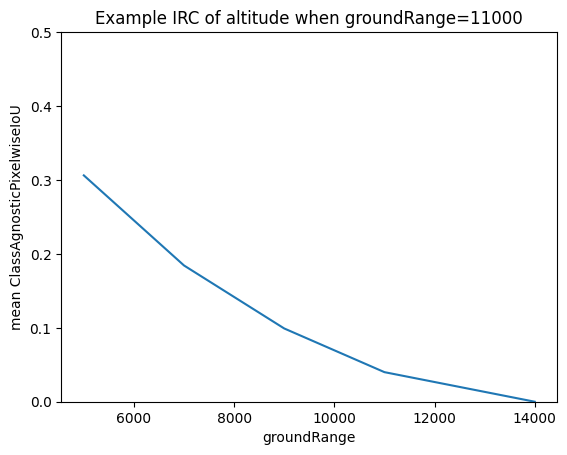

In [8]:
def plotter(x, y, xlabel, title):    
    plt.cla()
    plt.plot(x, y)
    plt.ylim([0, 0.5])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('mean ClassAgnosticPixelwiseIoU')
    plt.show()

x, y = list(), list()
for (params, score) in curve:
    if params['altitude'] == 5000:
        x.append(params['groundRange'])
        y.append(score)

plotter(x, y, xlabel = 'groundRange', title = 'Example IRC of groundRange when altitude=5000')

x, y = list(), list()
for (params, score) in curve:
    if params['altitude'] == 7000:
        x.append(params['groundRange'])
        y.append(score)

plotter(x, y, xlabel = 'groundRange', title = 'Example IRC of groundRange when altitude=7000')

x, y = list(), list()
for (params, score) in curve:
    if params['groundRange'] == 10000:
        x.append(params['altitude'])
        y.append(score)

plotter(x, y, xlabel = 'groundRange', title = 'Example IRC of altitude when groundRange=10000')

x, y = list(), list()
for (params, score) in curve:
    if params['groundRange'] == 11000:
        x.append(params['altitude'])
        y.append(score)

plotter(x, y, xlabel = 'groundRange', title = 'Example IRC of altitude when groundRange=11000')